In [1]:
from google.cloud import spanner
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spanner_client = spanner.Client()
instance = spanner_client.instance('ml-models-characterization-db')
database = instance.database('models_db')

/home/shobhitbehl/project/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/shobhitbehl/project/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com

In [3]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' GROUP BY model_name'
        ' ORDER BY model_name'
    )
    
total_ops = dict()
for row in results:
    total_ops[row[0]] = row[1]
    
print(total_ops)

{'albert_lite_base_squadv1_1': 2682, 'deeplabv3_1_default_1': 72, 'densenet': 251, 'inception_resnet_v2': 258, 'inception_v1_224_quant': 85, 'inception_v2_224_quant': 98, 'inception_v3_quant': 127, 'inception_v4_299_quant': 197, 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1': 172, 'mnasnet_1.3_224': 66, 'mobilebert_1_default_1': 2547, 'mobilenet_v1_1.0_224': 33, 'mobilenet_v1_1.0_224_quant': 33, 'mobilenet_v2_1.0_224_quant': 67, 'nasnet_large': 899, 'nasnet_mobile': 665, 'object_detection_mobile_object_localizer_v1_1_default_1': 120, 'posenet_mobilenet_float_075_1_default_1': 38, 'resnet_v2_101_299': 218, 'smartreply_1_default_1': 9, 'squeezenet': 42, 'ssd_mobilenet_v1_1_default_1': 69}


In [4]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) AS num_conv2d_layers'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type = \'CONV_2D\''
        ' GROUP BY model_name'
        ' ORDER BY num_conv2d_layers DESC;'
    )
    
conv2d_ops = dict()
for row in results:
    conv2d_ops[row[0]] = row[1]

print(conv2d_ops)

{'nasnet_large': 268, 'nasnet_mobile': 196, 'inception_resnet_v2': 188, 'inception_v4_299_quant': 149, 'resnet_v2_101_299': 105, 'inception_v3_quant': 95, 'inception_v2_224_quant': 70, 'densenet': 62, 'inception_v1_224_quant': 58, 'object_detection_mobile_object_localizer_v1_1_default_1': 55, 'deeplabv3_1_default_1': 38, 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1': 36, 'mobilenet_v2_1.0_224_quant': 36, 'mnasnet_1.3_224': 35, 'ssd_mobilenet_v1_1_default_1': 34, 'squeezenet': 26, 'posenet_mobilenet_float_075_1_default_1': 19, 'mobilenet_v1_1.0_224': 15, 'mobilenet_v1_1.0_224_quant': 15}


In [5]:
labels = list(total_ops.keys())
values = list()
for label in labels:
    if label not in conv2d_ops:
        values.append(0)
        continue
    values.append((conv2d_ops[label] / total_ops[label]) * 100)

print(labels)
print(values)

['albert_lite_base_squadv1_1', 'deeplabv3_1_default_1', 'densenet', 'inception_resnet_v2', 'inception_v1_224_quant', 'inception_v2_224_quant', 'inception_v3_quant', 'inception_v4_299_quant', 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1', 'mnasnet_1.3_224', 'mobilebert_1_default_1', 'mobilenet_v1_1.0_224', 'mobilenet_v1_1.0_224_quant', 'mobilenet_v2_1.0_224_quant', 'nasnet_large', 'nasnet_mobile', 'object_detection_mobile_object_localizer_v1_1_default_1', 'posenet_mobilenet_float_075_1_default_1', 'resnet_v2_101_299', 'smartreply_1_default_1', 'squeezenet', 'ssd_mobilenet_v1_1_default_1']
[0, 52.77777777777778, 24.701195219123505, 72.86821705426357, 68.23529411764706, 71.42857142857143, 74.80314960629921, 75.63451776649747, 20.930232558139537, 53.03030303030303, 0, 45.45454545454545, 45.45454545454545, 53.73134328358209, 29.810901001112345, 29.47368421052631, 45.83333333333333, 50.0, 48.1651376146789, 0, 61.904761904761905, 49.275362318840585]


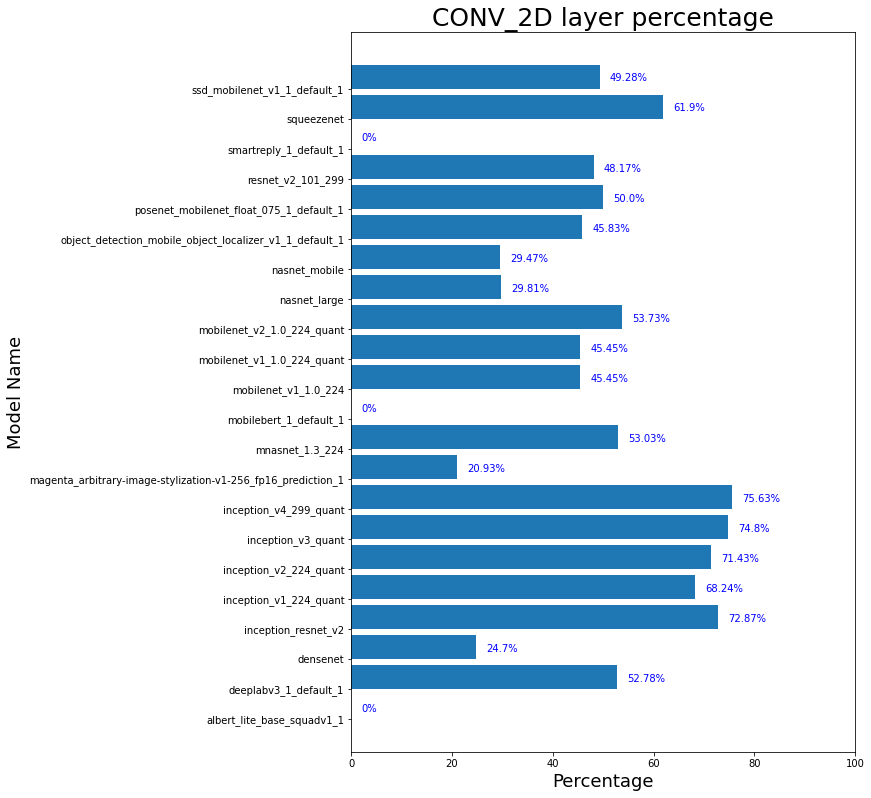

In [6]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("CONV_2D layer percentage", fontsize = 25)
ax.set_xlim([0, 100])
plt.barh(labels, values, align='edge')
ax.set_xlabel('Percentage', fontsize = 18)
ax.set_ylabel('Model Name', fontsize = 18)

for index, value in enumerate(values):
    ax.text(value + 2, index + .25, str(round(value,2)) + "%", color='blue')

plt.show()

In [7]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' GROUP BY category, operator_type'
        ' ORDER BY category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_op_dist['ImageClassification'])
print(category_op_dist['TextEmbedding'])
print(category_total_ops)

{'CONV_2D': 1318, 'DEPTHWISE_CONV_2D': 441, 'ADD': 376, 'RELU': 266, 'CONCATENATION': 203, 'AVERAGE_POOL_2D': 165, 'MUL': 103, 'MAX_POOL_2D': 53, 'SPLIT': 38, 'PAD': 12, 'SOFTMAX': 9, 'STRIDED_SLICE': 8, 'RESHAPE': 7, 'FULLY_CONNECTED': 6, 'MEAN': 5, 'SQUEEZE': 1}
{'RESHAPE': 1406, 'SLICE': 1010, 'FULLY_CONNECTED': 941, 'TRANSPOSE': 663, 'ADD': 500, 'MUL': 330, 'PACK': 146, 'MEAN': 50, 'SUB': 50, 'SOFTMAX': 36, 'SQUARED_DIFFERENCE': 25, 'RSQRT': 25, 'TANH': 12, 'POW': 12, 'GATHER': 4, 'PAD': 2, 'STRIDED_SLICE': 2, 'CAST': 2, 'UNPACK': 2, 'CONCATENATION': 1}
{'ImageClassification': 3011, 'ImagePoseDetection': 33, 'ImageSegmentation': 70, 'ImageStyleTransfer': 170, 'ObjectDetection': 179, 'TextEmbedding': 5219, 'TextGeneration': 6}


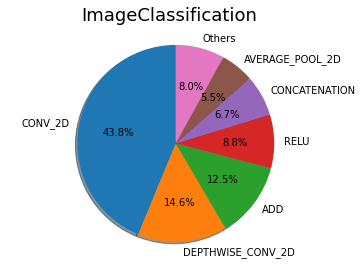

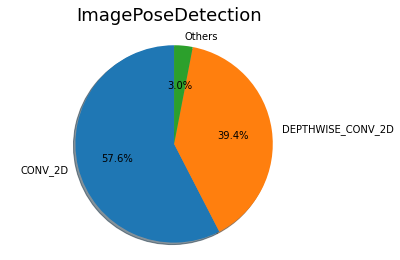

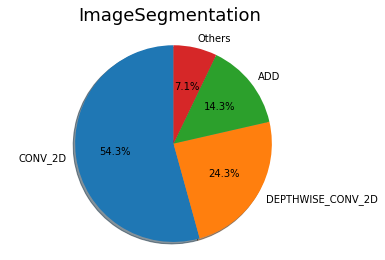

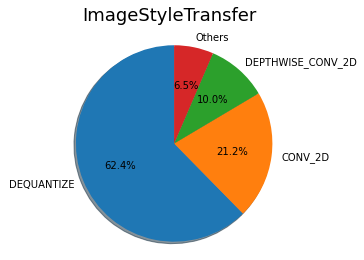

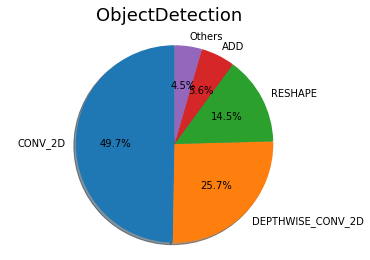

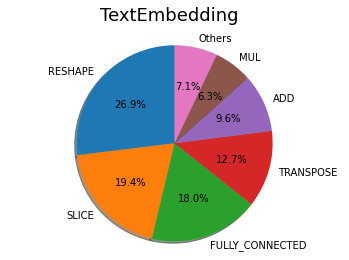

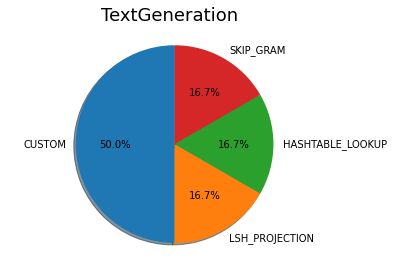

In [8]:
for category in categories:
    labels = list(category_op_dist[category].keys())
    values = list()
    
    for label in labels:
        val = (category_op_dist[category][label] / category_total_ops[category]) * 100
        
        values.append(val)
        
    cumm_val = 0
    for index in reversed(range(len(labels))):
        if cumm_val + values[index] > 10:
            break
        
        cumm_val += values[index]
        values.pop(index)
        labels.pop(index)
        
    
    if cumm_val != 0:
        labels.append("Others")
        values.append(cumm_val)
    
    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax.axis('equal') 
    fig.suptitle(category, fontsize = '18')
    plt.show()

In [9]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, padding, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' AND padding IS NOT NULL'
        ' GROUP BY operator_type, padding'
        ' ORDER BY operator_type, count DESC;'
    )

In [10]:
operation_padding = dict()

for row in results:
    if row[0] not in operation_padding:
        operation_padding[row[0]] = dict()
        operation_padding[row[0]]['SAME'] = 0
        operation_padding[row[0]]['VALID'] = 0

    operation_padding[row[0]][row[1]] = row[2]
    

labels = list(operation_padding.keys())
same_pad_values = list()
valid_pad_values = list()

for label in labels:
    same_num = operation_padding[label]['SAME']
    valid_num = operation_padding[label]['VALID']
    total = same_num + valid_num
    same_pad_values.append(round((same_num / total) *  100, 2))
    valid_pad_values.append(round((valid_num / total) * 100, 2))

print(labels)
print(same_pad_values)
print(valid_pad_values)

['AVERAGE_POOL_2D', 'CONV_2D', 'DEPTHWISE_CONV_2D', 'MAX_POOL_2D']
[84.34, 72.53, 100.0, 73.58]
[15.66, 27.47, 0.0, 26.42]


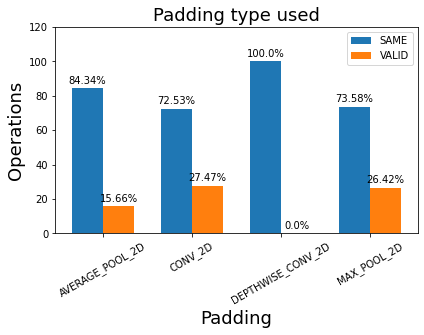

In [11]:
fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35
rects1 = ax.bar(x - width/2, same_pad_values, width, label='SAME')
rects2 = ax.bar(x + width/2, valid_pad_values, width, label='VALID')

ax.set_ylabel('Operations', fontsize = 18)
ax.set_xlabel('Padding', fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title("Padding type used", fontsize = 18)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + "%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=30)

ax.set_ylim([0, 120])

plt.show()


In [12]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT activation_function, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE activation_function IS NOT NULL AND activation_function != "NONE"'
        ' GROUP BY activation_function'
        ' ORDER BY count DESC;'
    )

['RELU', 'RELU6']
[13.18867924528302, 2.4716981132075473]


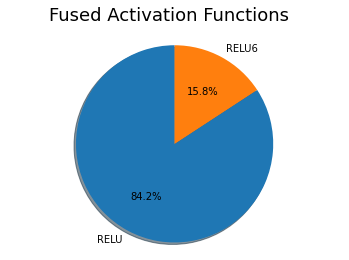

In [13]:
fused_activation_count = dict()
total_count = 0

for row in results:
    fused_activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(fused_activation_count.keys())
values = list()
for label in labels:
    values.append(fused_activation_count[label] / total)

print(labels)
print(values)


fig, ax = plt.subplots()
ax.pie(values, labels = labels, autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.axis('equal') 
fig.suptitle("Fused Activation Functions", fontsize = '18')
plt.show()